# Demand allocation
Demand satisfaction with capacity constraints. Dynamic structure.

In [26]:
from utilities.std_imports import *
from IPython.display import Image
import scipy.optimize as so

### Data definitions

$ d_i $  : Demand of customer i  
$ f_i $  : Fixed cost of warehouses rent  
$ M_i $  : Delivering capacity at warehouses  
$c_{ij}$ : Cost of transport from warehouse j to customer i  
$x_{ij}$ : Amount of goods to be transported from warehouse j to customer i

In [81]:
d = [80, 270, 250, 160, 180]
f = [1000, 1000, 1000]
M = [500, 500, 500]
C = np.array([[4,5,6,8,10],[6,4,3,5,8],[9,7,4,3,4]])

nC = 5
nW = 3

### Optimization problem

Minimize cost of transport $ \qquad \sum_{i=0}^{nC} \sum_{j=0}^{nW} c_{ij} x_{ij} $  

with :   
  
$ \sum_{j=0}^{nW} x_{ij} = d_i \quad $  (sum of orders from all warehouses for a customer satisfy total demand of the customer)  

$ \sum_{i=0}^{nC} x_{ij} \le M_j \quad $  (sum of orders for all costumers from one warehouse does not exceed capacity limit)

$ x_{ij} \ge 0 \quad $ (orderlines are always positive or zero)    

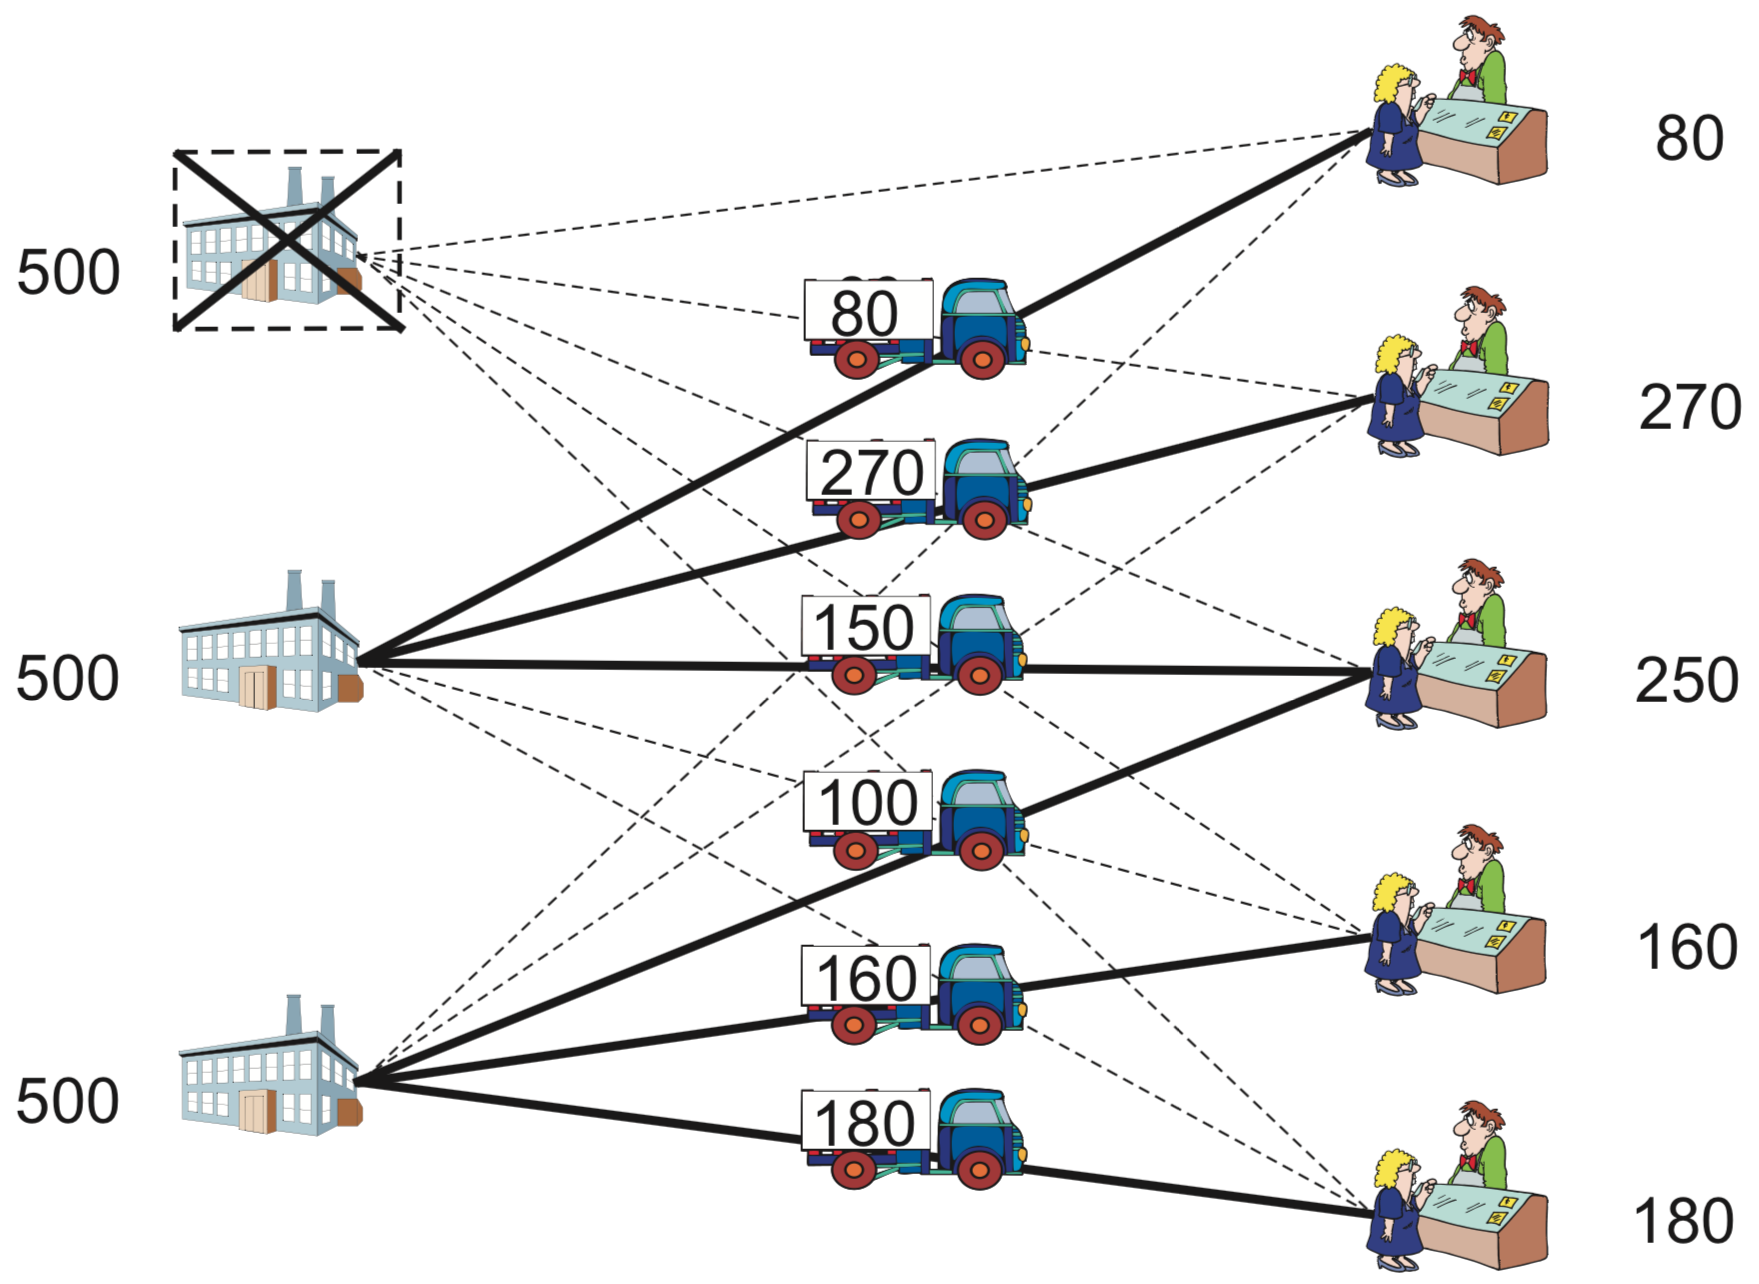

In [82]:
Image(filename='supply_chain/wms/flp.png', width = 600, height = 300) 

### Scipy

In [83]:
C1d = C.flatten()
C1d

array([ 4,  5,  6,  8, 10,  6,  4,  3,  5,  8,  9,  7,  4,  3,  4])

In [92]:
c = C1d

A_ub = [[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],  [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1]]  
b_ub = M


A_eq = [[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0], [0,1,0,0,0,0,1,0,0,0,0,1,0,0,0], [0,0,1,0,0,0,0,1,0,0,0,0,1,0,0], [0,0,0,1,0,0,0,0,1,0,0,0,0,1,0], [0,0,0,0,1,0,0,0,0,1,0,0,0,0,1]]   
b_eq = d

bounds = [(0, float("inf")),  (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf")), (0, float("inf"))] 

In [93]:
opt = so.linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="revised simplex")
opt

     con: array([0., 0., 0., 0., 0.])
     fun: 3370.0
 message: 'Optimization terminated successfully.'
     nit: 14
   slack: array([400.,   0., 160.])
  status: 0
 success: True
       x: array([ 80.,  20.,   0.,   0.,   0.,   0., 250., 250.,   0.,   0.,   0.,
         0.,   0., 160., 180.])

### SCIP

In [21]:
from pyscipopt import Model

def flp(I,J,d,M,f,c):
    model = Model("flp")
    x,y = {},{}
    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in I:
            x[i,j] = model.addVar(vtype="C", name="x(%s,%s)"%(i,j))
    for i in I:
        model.addCons(quicksum(x[i,j] for j in J) == d[i], "Demand(%s)"%i)
    for j in M:
        model.addCons(quicksum(x[i,j] for i in I) <= M[j]*y[j], "Capacity(%s)"%i)
    for (i,j) in x:
        model.addCons(x[i,j] <= d[i]*y[j], "Strong(%s,%s)"%(i,j))
    model.setObjective(quicksum(f[j]*y[j] for j in J) + quicksum(c[i,j]*x[i,j] for i in I for j in J), "minimize")
    model.data = x,y
    return model

# Credits & Links

https://scipbook.readthedocs.io/en/latest/intro.html#transportation-problem